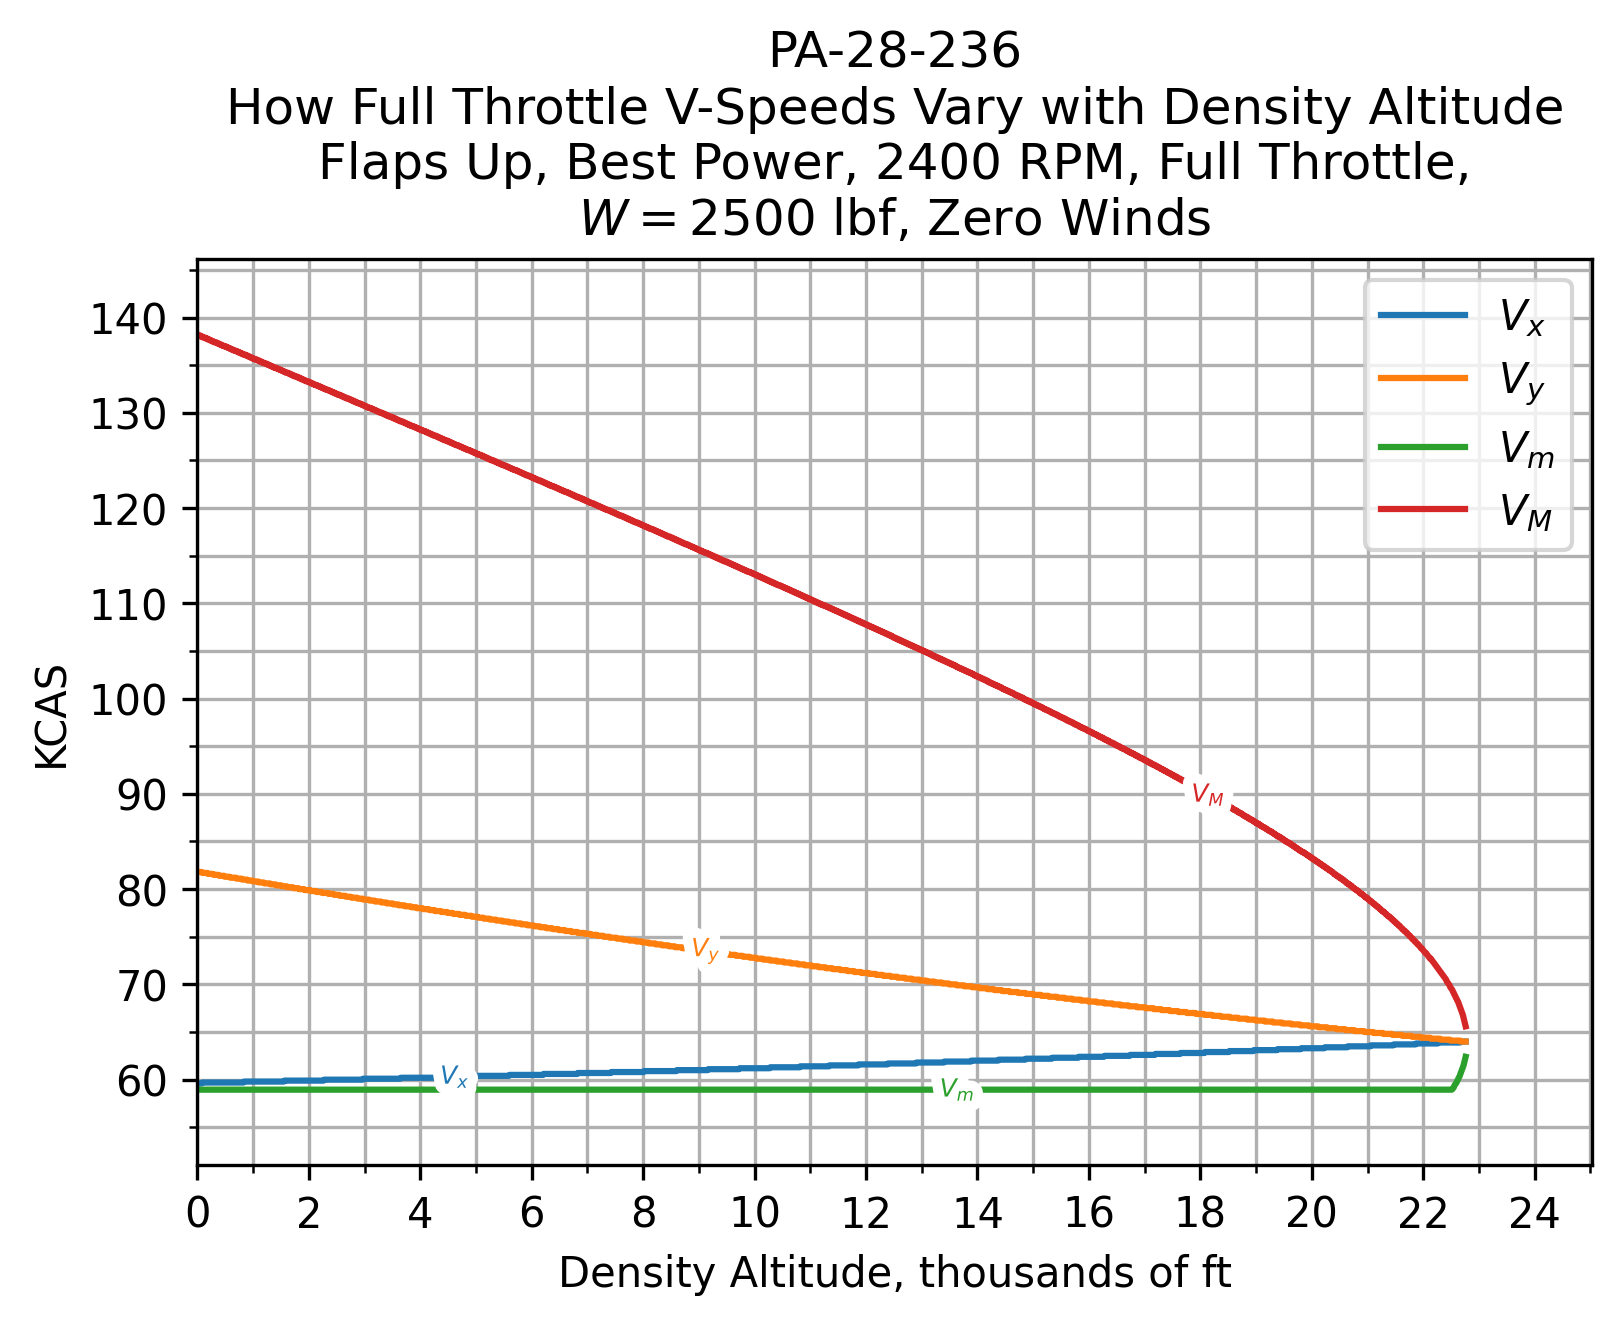

In [4]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from labellines import labelLines
from matplotlib.ticker import AutoMinorLocator, FuncFormatter, MultipleLocator

from n51sw_dataplate import N51SW
from the_bootstrap_approach.conditions import FullThrottleConditions
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.performance import (
    bootstrap_cruise_performance_table,
    ByKCASRowIndex,
)

gross_aircraft_weight = 2500
mixture = Mixture.BEST_POWER
# TODO: We only need extra precision towards the absolute ceiling at the very
# end.
pressure_altitude = np.linspace(0, 25000, 2000)

vx = []
vy = []
min_level_flight_speed = []
max_level_flight_speed = []

# According to POH, a Piper Dakota stalls at 65 KCAS at 3000 lbf and 0° flap.
# According to the airspeed calibration chart, this is approximately 65.5 KCAS.
stall_speed_at_mgw = 65.5

for i in pressure_altitude:
    operating_conditions = FullThrottleConditions(
        N51SW,
        gross_aircraft_weight,
        i,
        british_standard_temperature(i),
        mixture,
        2400,
    )

    table = bootstrap_cruise_performance_table(
        N51SW, operating_conditions, 30, 140, 0.1
    )

    # Vx, best angle of climb.
    aoc = table[:, ByKCASRowIndex.ANGLE_OF_CLIMB]
    index_of_highest_aoc = aoc.argmax()
    vx.append(table[index_of_highest_aoc][ByKCASRowIndex.KCAS])

    # Vy, best rate of climb.
    roc = table[:, ByKCASRowIndex.RATE_OF_CLIMB]
    index_of_highest_roc = roc.argmax()
    vy.append(table[index_of_highest_roc][ByKCASRowIndex.KCAS])

    # V_m, minimum level flight speed (in practice, Vm seldom occurs, because
    # the power-on stall speed is usually much higher).
    roc_before_peak = roc[:index_of_highest_roc]
    if roc_before_peak.size > 0:
        index_min_level_flight_speed = np.where(
            roc_before_peak > 0, roc_before_peak, np.inf
        ).argmin()
    else:
        index_min_level_flight_speed = 0
    stall_speed = scale_v_speed_by_weight(
        stall_speed_at_mgw, 3000, operating_conditions.gross_aircraft_weight
    )
    min_level_flight_speed.append(
        max(table[index_min_level_flight_speed][ByKCASRowIndex.KCAS], stall_speed)
    )

    # V_M, maximum level flight speed.
    roc_after_peak = roc[index_of_highest_roc:]
    index_max_level_flight_speed = np.where(
        roc_after_peak > 0, roc_after_peak, np.inf
    ).argmin()
    max_level_flight_speed.append(
        table[index_of_highest_roc + index_max_level_flight_speed][ByKCASRowIndex.KCAS]
    )

fig, ax = plt.subplots()

# Get the index of the peak of $V_m$. This is also where all four curves
# intersect. Crop the graph.
idx = np.array(min_level_flight_speed).argmax()
ax.plot(pressure_altitude[:idx], vx[:idx], label=r"$V_x$")
ax.plot(pressure_altitude[:idx], vy[:idx], label=r"$V_y$")
ax.plot(pressure_altitude[:idx], min_level_flight_speed[:idx], label=r"$V_m$")
ax.plot(pressure_altitude[:idx], max_level_flight_speed[:idx], label=r"$V_M$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

ax.set(
    xlabel="Density Altitude, thousands of ft",
    ylabel="KCAS",
    title=(
        "PA-28-236\n"
        "How Full Throttle V-Speeds Vary with Density Altitude\n"
        f"{N51SW.configuration}, "
        f"{mixture.value}, "
        f"2400 RPM, "
        f"Full Throttle,\n"
        f"$W = {gross_aircraft_weight}$ lbf, "
        f"Zero Winds"
    ),
)

ax.grid(True, which="both")

ax.xaxis.set_major_locator(MultipleLocator(2000))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000)))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))


# https://stackoverflow.com/questions/49382105/matplotlib-set-different-margins-for-left-and-right-side
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta * left
    right = lim[1] + delta * right
    ax.set_xlim(left, right)


set_xmargin(ax, right=0.1)
ax.margins(y=0.1)

# TODO: Add annotations for v-speeds and absolute ceiling.
plt.legend()

fig.set(dpi=300)
plt.show()